In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
import nltk
# We need to download the following to avoid errors.
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
import string
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from collections import defaultdict
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel
import umap.umap_ as umap
from sklearn.cluster import AgglomerativeClustering
!pip install hdbscan
import hdbscan
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

# Part 2

QUESTION 19: In a brief paragraph discuss: If the VGG network is trained on a dataset with perhaps totally different classes as targets, why would one expect the features derived from such a network to have discriminative power for a custom dataset?<br>
*VGG network includes many layers and filters. This helps the network to recognize a variety of complex shapes and objects. The early layers in VGG recognize simple shapes such as lines and edges and deeper layers recognize more complicated shapes such as people or vehicles. Since any type of image database we work with, even if it has completely different labels, will need network layers to recognize simple shapes (edges, lines, etc.), we can use features extracted from a pretrained VGG network. However, based on the dataset we are working with we might need to fine-tune some layers, especially final (deep) layers. This is the general idea of Transfer Learning.*

**NOTE:** Due to limitations of my computer, I ran Part 2 on Google Colab.

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

100%|██████████| 58/58 [00:43<00:00,  1.33it/s]


In [3]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


QUESTION 20: In a brief paragraph explain how the helper code base is performing feature extraction. <br>
*This code uses a number of layers from VGG16 network to build a custom feature extractor. The layers that are used in order are: 1)VGG-16 Feature Layers 2)VGG-16 Average Pooling Layer 3)flattening which is basically converting data into one dimensional array that can be used for fully connected layers and 4)the first section of fully-connected layer from VGG16 network. These layers are stacked to create a feature extraction model. There are a total of 4096 output features per data sample.*
<br>
QUESTION 21: How many pixels are there in the original images? How many features does the VGG network extract per image; i.e what is the dimension of each feature vector for an image sample? <br>
*The images are 3x224x224 which means they have 3 channels and 224 by 224 pixels on x and y axes. The feature vectors are 4096 dimensional.*

In [ ]:
print('sample image shape: ',x[0].shape)
print('feature vector shape per sample: ',num_features)

sample image shape:  torch.Size([3, 224, 224])
feature vector shape per sample:  4096


QUESTION 22: Are the extracted features dense or sparse? (Compare with sparse TF-IDF features in text.) <br>
*These features are dense. If we compare to text TF-IDF vectors that had more than 23k parameters and were dense, we realize that the image feature vectors have lower dimension but more information.* <br>

QUESTION 23: In order to inspect the high-dimensional features, t-SNE is a popular off-the-shelf choice for visualizing Vision features. Map the features you have extracted onto 2 dimensions with t-SNE. Then plot the mapped feature vectors along x and y axes. Color-code the data points with ground-truth labels. Describe your observation. <br>
*Based on the visualization below, it seems that the feature extraction method based on VGG is able to roughly separate data based on their different labels. There are some samples that are not separated well which hints that we might need to fine tune a few layers of the classification model we are using.*

Text(0.5, 0.98, 'Visualizing the t-SNE mapped feature vectors')

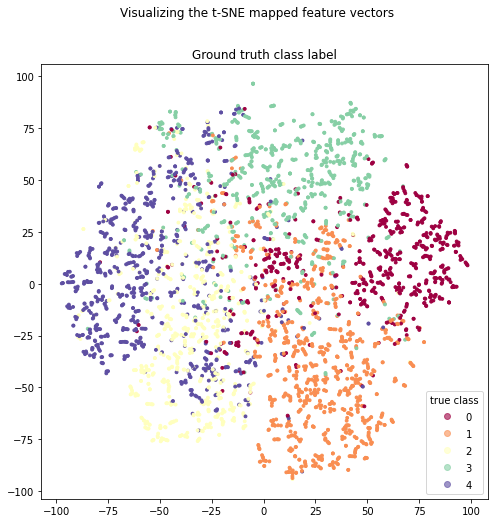

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random',
                  perplexity=3).fit_transform(f_all)
fig,ax1 = plt.subplots(1,1,figsize=(8, 8))
sc1 = ax1.scatter(X_embedded[:,0], X_embedded[:, 1], c=y_all,
                  cmap='Spectral', s=8)

ax1.set_title('Ground truth class label')

handles, labels = sc1.legend_elements(prop="colors", alpha=0.6)
leg1 = ax1.legend(handles, labels, loc="lower right", title="true class")

fig.suptitle('Visualizing the t-SNE mapped feature vectors')

In [4]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True),
             nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X,y=None):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X,y=None):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3,
                                     weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X, y=None):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

QUESTION 24: Report the best result (in terms of rand score) within the table below.
For HDBSCAN, introduce a conservative parameter grid over min cluster size and min samples. <br>
*Please see below for the evaluation of different combinations. I separately evaluated 3 clustering algorithms and then selected the one with the highest score (metrics.adjusted_rand_score)*

### Evaluation of K-Means

In [5]:
from sklearn.metrics import homogeneity_score, make_scorer
def score_func(y_true, y_pred, **kwargs):
    return metrics.adjusted_rand_score(y_true, y_pred)
    #return metrics.silhouette_score(y_true, y_pred)

scorer = make_scorer(score_func) 
params1 = {    
    'Dimensionality Reduction':['passthrough',TruncatedSVD(n_components=50),
                                umap.UMAP(n_components=50,metric = 'cosine'),
                               Autoencoder(n_components=50)
                               ],
    'Clustering': [KMeans(n_clusters=50, max_iter=1000,n_init=30,random_state=0),
                  ] 
    }

pipe1 = Pipeline([
                     ('Dimensionality Reduction',umap.UMAP(n_components = 50,
                                                           metric = 'cosine')),
                     ('Clustering',KMeans(max_iter=1000,n_init=30,random_state=0))
                    ])

search1 = GridSearchCV(pipe1, params1, cv=3, refit=True, verbose=2,
                       scoring=scorer)
search1.fit(f_all,y_all)
print("Best parameter score: (CV score=%0.3f) " % search1.best_score_)
print("Best combination: ",search1.best_params_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END Clustering=KMeans(max_iter=1000, n_clusters=50, n_init=30, random_state=0), Dimensionality Reduction=passthrough; total time= 1.4min
[CV] END Clustering=KMeans(max_iter=1000, n_clusters=50, n_init=30, random_state=0), Dimensionality Reduction=passthrough; total time= 1.3min
[CV] END Clustering=KMeans(max_iter=1000, n_clusters=50, n_init=30, random_state=0), Dimensionality Reduction=passthrough; total time= 1.3min
[CV] END Clustering=KMeans(max_iter=1000, n_clusters=50, n_init=30, random_state=0), Dimensionality Reduction=TruncatedSVD(n_components=50); total time=   7.5s
[CV] END Clustering=KMeans(max_iter=1000, n_clusters=50, n_init=30, random_state=0), Dimensionality Reduction=TruncatedSVD(n_components=50); total time=   5.8s
[CV] END Clustering=KMeans(max_iter=1000, n_clusters=50, n_init=30, random_state=0), Dimensionality Reduction=TruncatedSVD(n_components=50); total time=   7.3s
[CV] END Clustering=KMeans(max_ite

100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


[CV] END Clustering=KMeans(max_iter=1000, n_clusters=50, n_init=30, random_state=0), Dimensionality Reduction=Autoencoder(); total time=  21.9s


100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


[CV] END Clustering=KMeans(max_iter=1000, n_clusters=50, n_init=30, random_state=0), Dimensionality Reduction=Autoencoder(); total time=  22.5s


100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


[CV] END Clustering=KMeans(max_iter=1000, n_clusters=50, n_init=30, random_state=0), Dimensionality Reduction=Autoencoder(); total time=  20.7s
Best parameter (CV score=0.138) score:
Best combination:  {'Clustering': KMeans(max_iter=1000, n_clusters=50, n_init=30, random_state=0), 'Dimensionality Reduction': UMAP(metric='cosine', n_components=50)}


### Evaluation of AgglomerativeClustering

In [6]:
dim_alg = ['passthrough',TruncatedSVD(n_components=50),
                                umap.UMAP(n_components=50,metric = 'cosine'),
                               Autoencoder(n_components=50)
                               ]
best_alg = None
best_score = float('-inf')

for alg in dim_alg:
    
    pipe2 = Pipeline([
                     ('Dimensionality Reduction',alg),
                     ('Clustering',AgglomerativeClustering(n_clusters=5,
                                                           linkage='ward'))
                    ])
    
    pipe2.fit(f_all)
    labels_pred = pipe2['Clustering'].labels_
    score = metrics.adjusted_rand_score(y_all, labels_pred)
    if score>best_score:
        best_score = score
        best_alg = alg

        
print("Best parameter for Agglomerative Clustering gives score: (CV score=%0.3f)" % best_score)
print("Best dimension reduction algorithm: ",best_alg)
    
    
    

100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


Best parameter  for Agglomerative Clustering gives score: (CV score=0.456)
Best dimension reduction algorithm:  UMAP(angular_rp_forest=True, metric='cosine', n_components=50, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


### Evaluation of HDBSCAN


In [8]:
best_alg = None
best_score = float('-inf')

Clustering__min_cluster_size=[50,100]
Clustering__min_samples=[50,200]
best_cluster_size = None
best_samples = None

for alg in dim_alg:
    for c in Clustering__min_cluster_size:
        for s in Clustering__min_samples:
            print(f'checking min_cluster_size {c} and min_samples {s}')
            pipe3 = Pipeline([
                     ('Dimensionality Reduction',umap.UMAP(n_components = 20, metric = 'cosine')),
                     ('Clustering',hdbscan.HDBSCAN(min_cluster_size = c, min_samples=s, metric='manhattan'))
                    ])
            
            pipe3.fit(f_all)
            labels_pred = pipe3['Clustering'].labels_
            score = metrics.adjusted_rand_score(y_all, labels_pred)
            if score>best_score:
                best_score = score
                best_alg = alg
                best_cluster_size = c
                best_samples = s
print("Best parameter for HDBSCAN Clustering gives score: (CV score=%0.3f)" % best_score)
print("Best dimension reduction algorithm: ",best_alg)
print("Best min_cluster_size: ",best_cluster_size)
print("Best min_samples: ",best_samples)

checking min_cluster_size 50 and min_samples 50
checking min_cluster_size 50 and min_samples 200
checking min_cluster_size 100 and min_samples 50
checking min_cluster_size 100 and min_samples 200
checking min_cluster_size 50 and min_samples 50
checking min_cluster_size 50 and min_samples 200
checking min_cluster_size 100 and min_samples 50
checking min_cluster_size 100 and min_samples 200
checking min_cluster_size 50 and min_samples 50
checking min_cluster_size 50 and min_samples 200
checking min_cluster_size 100 and min_samples 50
checking min_cluster_size 100 and min_samples 200
checking min_cluster_size 50 and min_samples 50
checking min_cluster_size 50 and min_samples 200
checking min_cluster_size 100 and min_samples 50
checking min_cluster_size 100 and min_samples 200
Best parameter for HDBSCAN Clustering gives score: (CV score=0.371)
Best dimension reduction algorithm:  UMAP(angular_rp_forest=True, metric='cosine', n_components=50, tqdm_kwds={'bar_format': '{desc}: {percentage:3.

Based on these results, the best choice is: <br>
*Best parameter  for Agglomerative Clustering gives score: (CV score=0.456)
Best dimension reduction algorithm:  UMAP( metric='cosine', n_components=50)*

QUESTION 25: Report the test accuracy of the MLP classifier on the original VGG features. Report the same when using the reduced-dimension features (you have freedom in choosing the dimensionality reduction algorithm and its parameters). Does the performance of the model suffer with the reduced-dimension representations? Is it significant? Does the success in classification make sense in the context of the clustering results obtained for the same features in Question 24. <br>
*Please see below:*

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):#100
            
            for i,(X_, y_) in enumerate(dataloader):
                ##################################
                # you should implement this part #
                ##################################
                #raise NotImplementedError

                # reset gradients
                optimizer.zero_grad()

                # forward pass
                pred = self.model(X_)
                # compute loss
                loss = criterion(pred, y_)
                # backward pass 
                loss.backward()
                # optimize
                optimizer.step()
                
        return self
    
    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        ##################################
        #raise NotImplementedError
        classes = list(range(0,5))
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}

        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')

        dataset = TensorDataset(X_test, y_test)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

        with torch.no_grad():
          for data in dataloader:
              images, labels = data
              outputs = self.model(images)
              _, predictions = torch.max(outputs, 1)
              # collect the correct predictions for each class
              for label, prediction in zip(labels, predictions):
                  if label == prediction:
                      correct_pred[classes[label]] += 1
                  total_pred[classes[label]] += 1

        accuracy = [0 for i in range(5)]
        for classname, correct_count in correct_pred.items():
              accuracy[classname] = 100 * float(correct_count) / total_pred[classname]
              print(f'accuracy of class {classname}: ',accuracy[classname])

        avg_acc = np.mean(accuracy)
        print('average accuracy: ',avg_acc)
        return avg_acc


In [ ]:
"""
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder()
y_all = encoder.fit_transform(y_all.reshape(-1, 1))
"""
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2, random_state=42)

### Evaluating MLP classifier on the original VGG features

In [ ]:
from sklearn.model_selection import train_test_split
classifier = MLP(num_features = f_all.shape[1])
classifier.train(X_train,y_train)
acc = classifier.eval(X_test,y_test)


100%|██████████| 100/100 [00:08<00:00, 11.73it/s]


accuracy of class 0:  92.06349206349206
accuracy of class 1:  97.02380952380952
accuracy of class 2:  85.9375
accuracy of class 3:  93.89312977099236
accuracy of class 4:  86.1878453038674
average accuracy:  91.02115533243226


### Evaluating MLP classifier on the reduced dimension vectors

In [ ]:
alg = umap.UMAP(metric='cosine', n_components=50)
X_tr = alg.fit_transform(X_train)
X_ts = alg.transform(X_test)

classifier = MLP(num_features = X_tr.shape[1])

classifier.train(X_tr,y_train)
acc = classifier.eval(X_ts,y_test)


100%|██████████| 100/100 [00:05<00:00, 17.40it/s]

accuracy of class 0:  89.68253968253968
accuracy of class 1:  92.26190476190476
accuracy of class 2:  75.78125
accuracy of class 3:  81.6793893129771
accuracy of class 4:  81.21546961325967
average accuracy:  84.12411067413625


*The average testing accuracty is slightly lower when we use dimensionality reduction algorithm. This difference can be considered significant given the low number of classes. The clustering results with these features were relatively satisfactory in Q24 when using rand score so the result of Q25 does make sense.*